In [1]:
import tensorflow as tf
import pandas as pd
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt


In [2]:
'''from google.colab import drive



# Mount Google Drive

drive.mount('/content/drive')
'''

"from google.colab import drive\n\n\n\n# Mount Google Drive\n\ndrive.mount('/content/drive')\n"

In [3]:
import pandas as pd

combined_df = pd.read_csv("/kaggle/input/combined-df/combined_df.csv")



combined_df

,label,text
0,1,CPPRI Recruitment 2010 at http://ping.fm/yp8zH
1,1,National Games Secretariat Recruitment 2010 :...
2,1,CIPET Recruitment Jobs at http://ping.fm/KnFCa
3,1,DIAT Recruitment 2010 at http://ping.fm/huS9m
4,1,BHEL Recruitment 2010 : http://ping.fm/PLWWA
...,...,...
1193663,0,http://t.co/pzOicLAz
1193664,0,you ain't nothin but a hoochie mamma.... hood ...
1193665,0,watching The Sweetest Thing!!!!
1193666,0,Looking like a library kind of day


In [4]:
combined_df["label"].value_counts()

label
0    1048574
1     145094
Name: count, dtype: int64

In [5]:
import pandas as pd

num_bots = combined_df[combined_df['label'] == 1].shape[0]

# Randomly select the same number of genuine samples
genuine_samples = combined_df[combined_df['label'] == 0].sample(n=num_bots, random_state=42)

#  Combine the undersampled genuine samples with all bot samples
undersampled_df = pd.concat([genuine_samples, combined_df[combined_df['label'] == 1]], ignore_index=True)


# Shuffle the combined dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(undersampled_df["label"].value_counts())


label
1    145094
0    145094
Name: count, dtype: int64


In [6]:
import re

# Preprocessing function

def preprocess_text(text):

    text = text.lower()

    # Replace special Twitter elements with predefined tokens

    text = re.sub(r'@\w+', 'USER', text)  # Replace mentions with USER

    text = re.sub(r'#\w+', 'HASHTAG', text)  # Replace hashtags with HASHTAG

    text = re.sub(r'http\S+', 'URL', text)  # Replace URLs with URL

    return text

In [7]:
undersampled_df['text'] = undersampled_df['text'].astype(str).apply(preprocess_text)


In [8]:
# Tokenize and prepare dataset using the tokenizer

def tokenize_data(texts):

    return tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='tf')


In [9]:
# Split the data

from sklearn.model_selection import train_test_split

train_tweets, test_tweets, train_labels, test_labels = train_test_split(

    undersampled_df['text'].tolist(),

    undersampled_df['label'].tolist(),

    test_size=0.2,

    random_state=42

)

In [10]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast



# Initialize the tokenizer

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Convert to TensorFlow dataset

train_encodings = tokenize_data(train_tweets)

test_encodings = tokenize_data(test_tweets)


In [12]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast



# Initialize the model

model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(100).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(64)


In [14]:


# Compile the model

learning_rate = 5e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(

    optimizer=optimizer,

    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),

    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]

)


In [15]:
'''from tensorflow.keras.callbacks import EarlyStopping



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

'''

"from tensorflow.keras.callbacks import EarlyStopping\n\n\n\nearly_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)\n\n"

In [16]:


# Train the model

epochs = 2

history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)


Epoch 1/2
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1730467853.411804      82 service.cc:145] XLA service 0x5ce0e7bb6d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730467853.411845      82 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730467853.411849      82 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730467853.572697      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3628/3628 [==============================] - 3161s 857ms/step - loss: 0.1297 - accuracy: 0.9499 - val_loss: 0.1028 - val_accuracy: 0.9596
Epoch 2/2
3628/3628 [==============================] - 3109s 857ms/step - loss: 0.0706 - accuracy: 0.9739 - val_loss: 0.1074 - val_accuracy: 0.9636


In [17]:
# Evaluate the model on the test set

eval_results = model.evaluate(test_dataset)

print(f"Test loss: {eval_results[0]}, Test accuracy: {eval_results[1]}")


907/907 [==============================] - 263s 290ms/step - loss: 0.1074 - accuracy: 0.9636
Test loss: 0.10744253545999527, Test accuracy: 0.963627278804779


In [18]:
# Evaluate the model on the training set to calculate training accuracy
train_eval_results = model.evaluate(train_dataset)
print(f"Train loss: {train_eval_results[0]}, Train accuracy: {train_eval_results[1]}")



3628/3628 [==============================] - 1054s 291ms/step - loss: 0.0410 - accuracy: 0.9818
Train loss: 0.041023094207048416, Train accuracy: 0.9818307161331177


In [19]:
# Predictions for calculating additional metrics

preds = model.predict(test_dataset)

y_pred_prob = tf.sigmoid(preds.logits).numpy().flatten()  # Flatten to shape (n_samples,)

y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert probabilities to binary


907/907 [==============================] - 268s 291ms/step


In [20]:
# Calculate precision, recall, and F1-score

precision, recall, f1, _ = precision_recall_fscore_support(test_labels, y_pred, average='binary')

print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")


Precision: 0.985758981551408, Recall: 0.9440024795949995, F1-score: 0.9644289634789952


In [21]:
import pandas as pd

# Assuming eval_results and train_eval_results are obtained from model.evaluate()
train_accuracy = train_eval_results[1]
test_accuracy = eval_results[1]

# Create a DataFrame to hold the accuracies
accuracy_data = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [train_accuracy, test_accuracy]
}

accuracy_df = pd.DataFrame(accuracy_data)
print(accuracy_df)

  Dataset  Accuracy
0   Train  0.981831
1    Test  0.963627


907/907 [==============================] - 265s 292ms/step


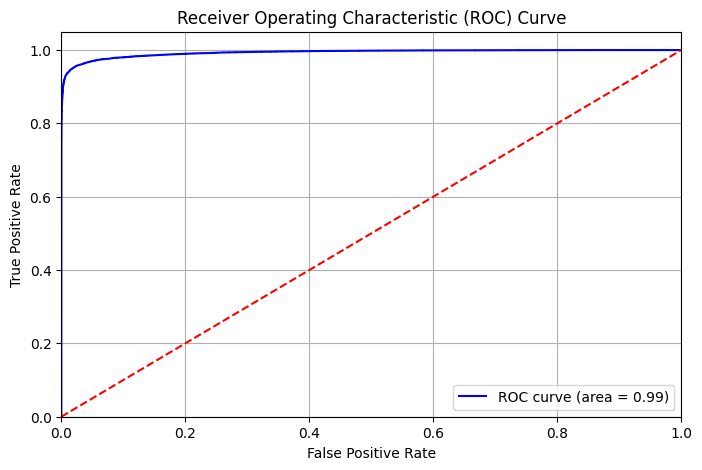

In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming test_labels is a NumPy array or a list of true labels
y_true = test_labels  

# Get predictions from the model
preds = model.predict(test_dataset)

# Extract logits from TFSequenceClassifierOutput
logits = preds.logits  # Extract logits

# Convert logits to probabilities using sigmoid
y_scores = tf.sigmoid(logits).numpy().flatten()  # Flatten to shape (n_samples,)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


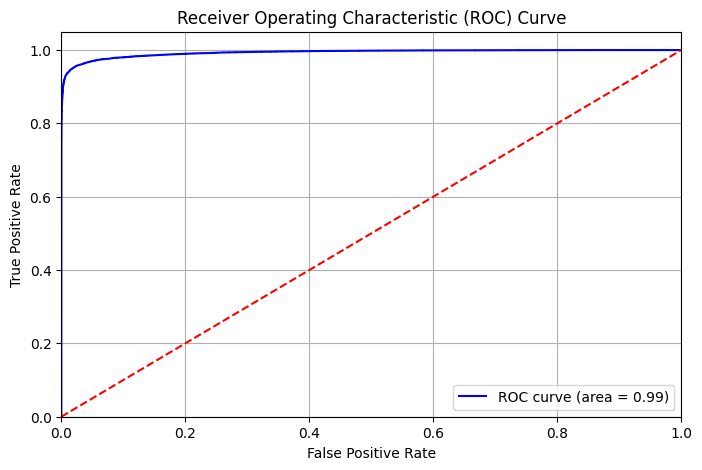

In [23]:
# Plotting the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()